# UMAP Visualization with Full Feature Set
Comprehensive UMAP analysis using all available user features from the master dataset.

In [1]:
import os
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

print("📊 Loading comprehensive user data for UMAP visualization...\n")

# --- Paths ---
base = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\aggregator\data"
master_path = os.path.join(base, "user_period_master_complete.parquet")

con = duckdb.connect()

# Load ALL available features and aggregate by user (across all periods)
user_features = con.execute(f"""
    SELECT 
        userId,
        -- Activity counts (totals across all periods)
        SUM(COALESCE(total_notes_authored, 0)) as total_notes,
        SUM(COALESCE(total_ratings, 0)) as total_ratings,
        SUM(COALESCE(total_requests, 0)) as total_requests,
        
        -- Classification ratios
        SUM(COALESCE(not_misleading_count, 0))::FLOAT / NULLIF(SUM(COALESCE(total_notes_authored, 0)), 0) as not_misleading_ratio,
        SUM(COALESCE(misleading_count, 0))::FLOAT / NULLIF(SUM(COALESCE(total_notes_authored, 0)), 0) as misleading_ratio,
        
        -- Rating behavior
        SUM(COALESCE(helpful_count, 0))::FLOAT / NULLIF(SUM(COALESCE(total_ratings, 0)), 0) as helpful_rating_ratio,
        SUM(COALESCE(not_helpful_count, 0))::FLOAT / NULLIF(SUM(COALESCE(total_ratings, 0)), 0) as not_helpful_rating_ratio,
        
        -- Quality metrics (averages)
        AVG(avg_trustworthy_sources) as avg_trustworthy_sources,
        AVG(avg_is_media_note) as avg_is_media_note,
        
        -- Note status success rates
        SUM(COALESCE(currently_helpful_count, 0))::FLOAT / NULLIF(SUM(COALESCE(total_notes_authored, 0)), 0) as note_helpful_rate,
        SUM(COALESCE(currently_not_helpful_count, 0))::FLOAT / NULLIF(SUM(COALESCE(total_notes_authored, 0)), 0) as note_not_helpful_rate,
        
        -- Core note scores
        AVG(avg_core_note_intercept) as avg_intercept,
        AVG(avg_core_note_factor1) as avg_factor1,
        
        -- Helpful vs not helpful analysis
        AVG(avg_intercept_helpful) as avg_intercept_helpful,
        AVG(avg_intercept_not_helpful) as avg_intercept_not_helpful,
        AVG(intercept_diff_helpful_minus_not) as intercept_diff,
        
        -- Request behavior
        SUM(COALESCE(requests_with_source_link, 0))::FLOAT / NULLIF(SUM(COALESCE(total_requests, 0)), 0) as source_link_ratio,
        
        -- Temporal features
        COUNT(DISTINCT period_start) as active_periods,
        MIN(period_start) as first_active_period,
        MAX(period_start) as last_active_period
        
    FROM read_parquet('{master_path}')
    GROUP BY userId
    HAVING SUM(COALESCE(total_notes_authored, 0)) + 
           SUM(COALESCE(total_ratings, 0)) + 
           SUM(COALESCE(total_requests, 0)) >= 1
    ORDER BY userId
""").fetchdf()

con.close()

print(f"✅ Data loaded: {len(user_features):,} users")
print(f"📋 Features: {len(user_features.columns) - 1} feature columns\n")

# Display summary
print("Feature summary:")
print(user_features.describe())

📊 Loading comprehensive user data for UMAP visualization...



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ Data loaded: 1,279,178 users
📋 Features: 20 feature columns

Feature summary:
        total_notes  total_ratings  total_requests  not_misleading_ratio  \
count  1.279178e+06   1.279178e+06    1.279178e+06         275499.000000   
mean   1.629550e+00   1.336082e+02    8.024216e-01              0.266769   
min    0.000000e+00   0.000000e+00    0.000000e+00              0.000000   
25%    0.000000e+00   8.000000e+00    0.000000e+00              0.000000   
50%    0.000000e+00   3.100000e+01    0.000000e+00              0.000000   
75%    0.000000e+00   1.010000e+02    0.000000e+00              0.500000   
max    5.466400e+04   1.218030e+05    5.636300e+04              1.000000   
std    5.252895e+01   5.177422e+02    5.388250e+01              0.361691   

       misleading_ratio  helpful_rating_ratio  not_helpful_rating_ratio  \
count     275499.000000          1.278615e+06              1.278615e+06   
mean           0.733230          7.446441e-01              2.553559e-01   
min       

In [2]:
print("🔧 Preparing features for UMAP...\n")

# Select numeric features only
feature_cols = [col for col in user_features.columns if col not in ['userId', 'first_active_period', 'last_active_period']]

# Create feature matrix
X = user_features[feature_cols].copy()

# Handle missing values (fill with 0 for ratios, median for others)
print("Handling missing values...")
for col in X.columns:
    if 'ratio' in col or 'rate' in col:
        X[col] = X[col].fillna(0)
    else:
        X[col] = X[col].fillna(X[col].median())

# Standardize features
print("Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Feature matrix prepared: {X_scaled.shape}")
print(f"   {X_scaled.shape[0]:,} users × {X_scaled.shape[1]} features\n")

# Show which features are included
print("📊 Features included in UMAP:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

🔧 Preparing features for UMAP...

Handling missing values...
Standardizing features...
Standardizing features...
✅ Feature matrix prepared: (1279178, 18)
   1,279,178 users × 18 features

📊 Features included in UMAP:
   1. total_notes
   2. total_ratings
   3. total_requests
   4. not_misleading_ratio
   5. misleading_ratio
   6. helpful_rating_ratio
   7. not_helpful_rating_ratio
   8. avg_trustworthy_sources
   9. avg_is_media_note
  10. note_helpful_rate
  11. note_not_helpful_rate
  12. avg_intercept
  13. avg_factor1
  14. avg_intercept_helpful
  15. avg_intercept_not_helpful
  16. intercept_diff
  17. source_link_ratio
  18. active_periods
✅ Feature matrix prepared: (1279178, 18)
   1,279,178 users × 18 features

📊 Features included in UMAP:
   1. total_notes
   2. total_ratings
   3. total_requests
   4. not_misleading_ratio
   5. misleading_ratio
   6. helpful_rating_ratio
   7. not_helpful_rating_ratio
   8. avg_trustworthy_sources
   9. avg_is_media_note
  10. note_helpful_ra

In [5]:
import time

print("🎨 Computing UMAP projection on sampled data...\n")

# Sample users for faster computation
sample_size = 50000  # 50k users instead of 1.2M
print(f"Sampling {sample_size:,} users from {len(X_scaled):,} total users...")
np.random.seed(42)
sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)
X_scaled_sample = X_scaled[sample_idx]
user_features_sample = user_features.iloc[sample_idx].reset_index(drop=True)

print(f"Sample prepared: {X_scaled_sample.shape}")
print("This should take 5-15 minutes...\n")

start_time = time.time()

# UMAP projection - optimized for large datasets
reducer = umap.UMAP(
    n_neighbors=15,        # Balance between local and global structure
    min_dist=0.1,          # Minimum distance between points
    n_components=2,        # 2D projection
    metric='euclidean',    # Distance metric
    random_state=42,
    n_jobs=-1,             # Use all CPU cores
    verbose=True           # Show progress
)

X_umap = reducer.fit_transform(X_scaled_sample)

elapsed = time.time() - start_time
print(f"\n✅ UMAP projection complete in {elapsed/60:.1f} minutes!")
print(f"   Embedding shape: {X_umap.shape}")
print(f"   Sampled {sample_size:,} of {len(X_scaled):,} users ({100*sample_size/len(X_scaled):.1f}%)")

# Save the UMAP embedding for reuse
import pickle
umap_save_path = os.path.join(
    r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\clustering\data",
    f"umap_embedding_sample_{sample_size}.pkl"
)
with open(umap_save_path, 'wb') as f:
    pickle.dump({
        'X_umap': X_umap,
        'user_ids': user_features_sample['userId'].values,
        'feature_names': feature_cols,
        'sample_size': sample_size,
        'sample_idx': sample_idx
    }, f)
print(f"💾 UMAP embedding saved to: {umap_save_path}")

🎨 Computing UMAP projection on sampled data...

Sampling 50,000 users from 1,279,178 total users...
Sample prepared: (50000, 18)
This should take 5-15 minutes...

UMAP(n_jobs=1, random_state=42, verbose=True)
Wed Nov 12 00:39:55 2025 Construct fuzzy simplicial set
Wed Nov 12 00:39:55 2025 Finding Nearest Neighbors
Wed Nov 12 00:39:55 2025 Building RP forest with 16 trees
Sample prepared: (50000, 18)
This should take 5-15 minutes...

UMAP(n_jobs=1, random_state=42, verbose=True)
Wed Nov 12 00:39:55 2025 Construct fuzzy simplicial set
Wed Nov 12 00:39:55 2025 Finding Nearest Neighbors
Wed Nov 12 00:39:55 2025 Building RP forest with 16 trees
Wed Nov 12 00:39:56 2025 NN descent for 16 iterations
Wed Nov 12 00:39:56 2025 NN descent for 16 iterations
	 1  /  16
	 1  /  16
	 2  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Wed Nov 12 00:39:57 2025 Finished Nearest Neighbor Search
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Wed Nov 12 0

Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Nov 12 00:40:29 2025 Finished embedding

✅ UMAP projection complete in 0.6 minutes!
   Embedding shape: (50000, 2)
   Sampled 50,000 of 1,279,178 users (3.9%)
💾 UMAP embedding saved to: C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\clustering\data\umap_embedding_sample_50000.pkl
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Nov 12 00:40:29 2025 Finished embedding

✅ UMAP projection complete in 0.6 minutes!
   Embedding shape: (50000, 2)
   Sampled 50,000 of 1,279,178 u

📊 Creating UMAP visualizations colored by different features...



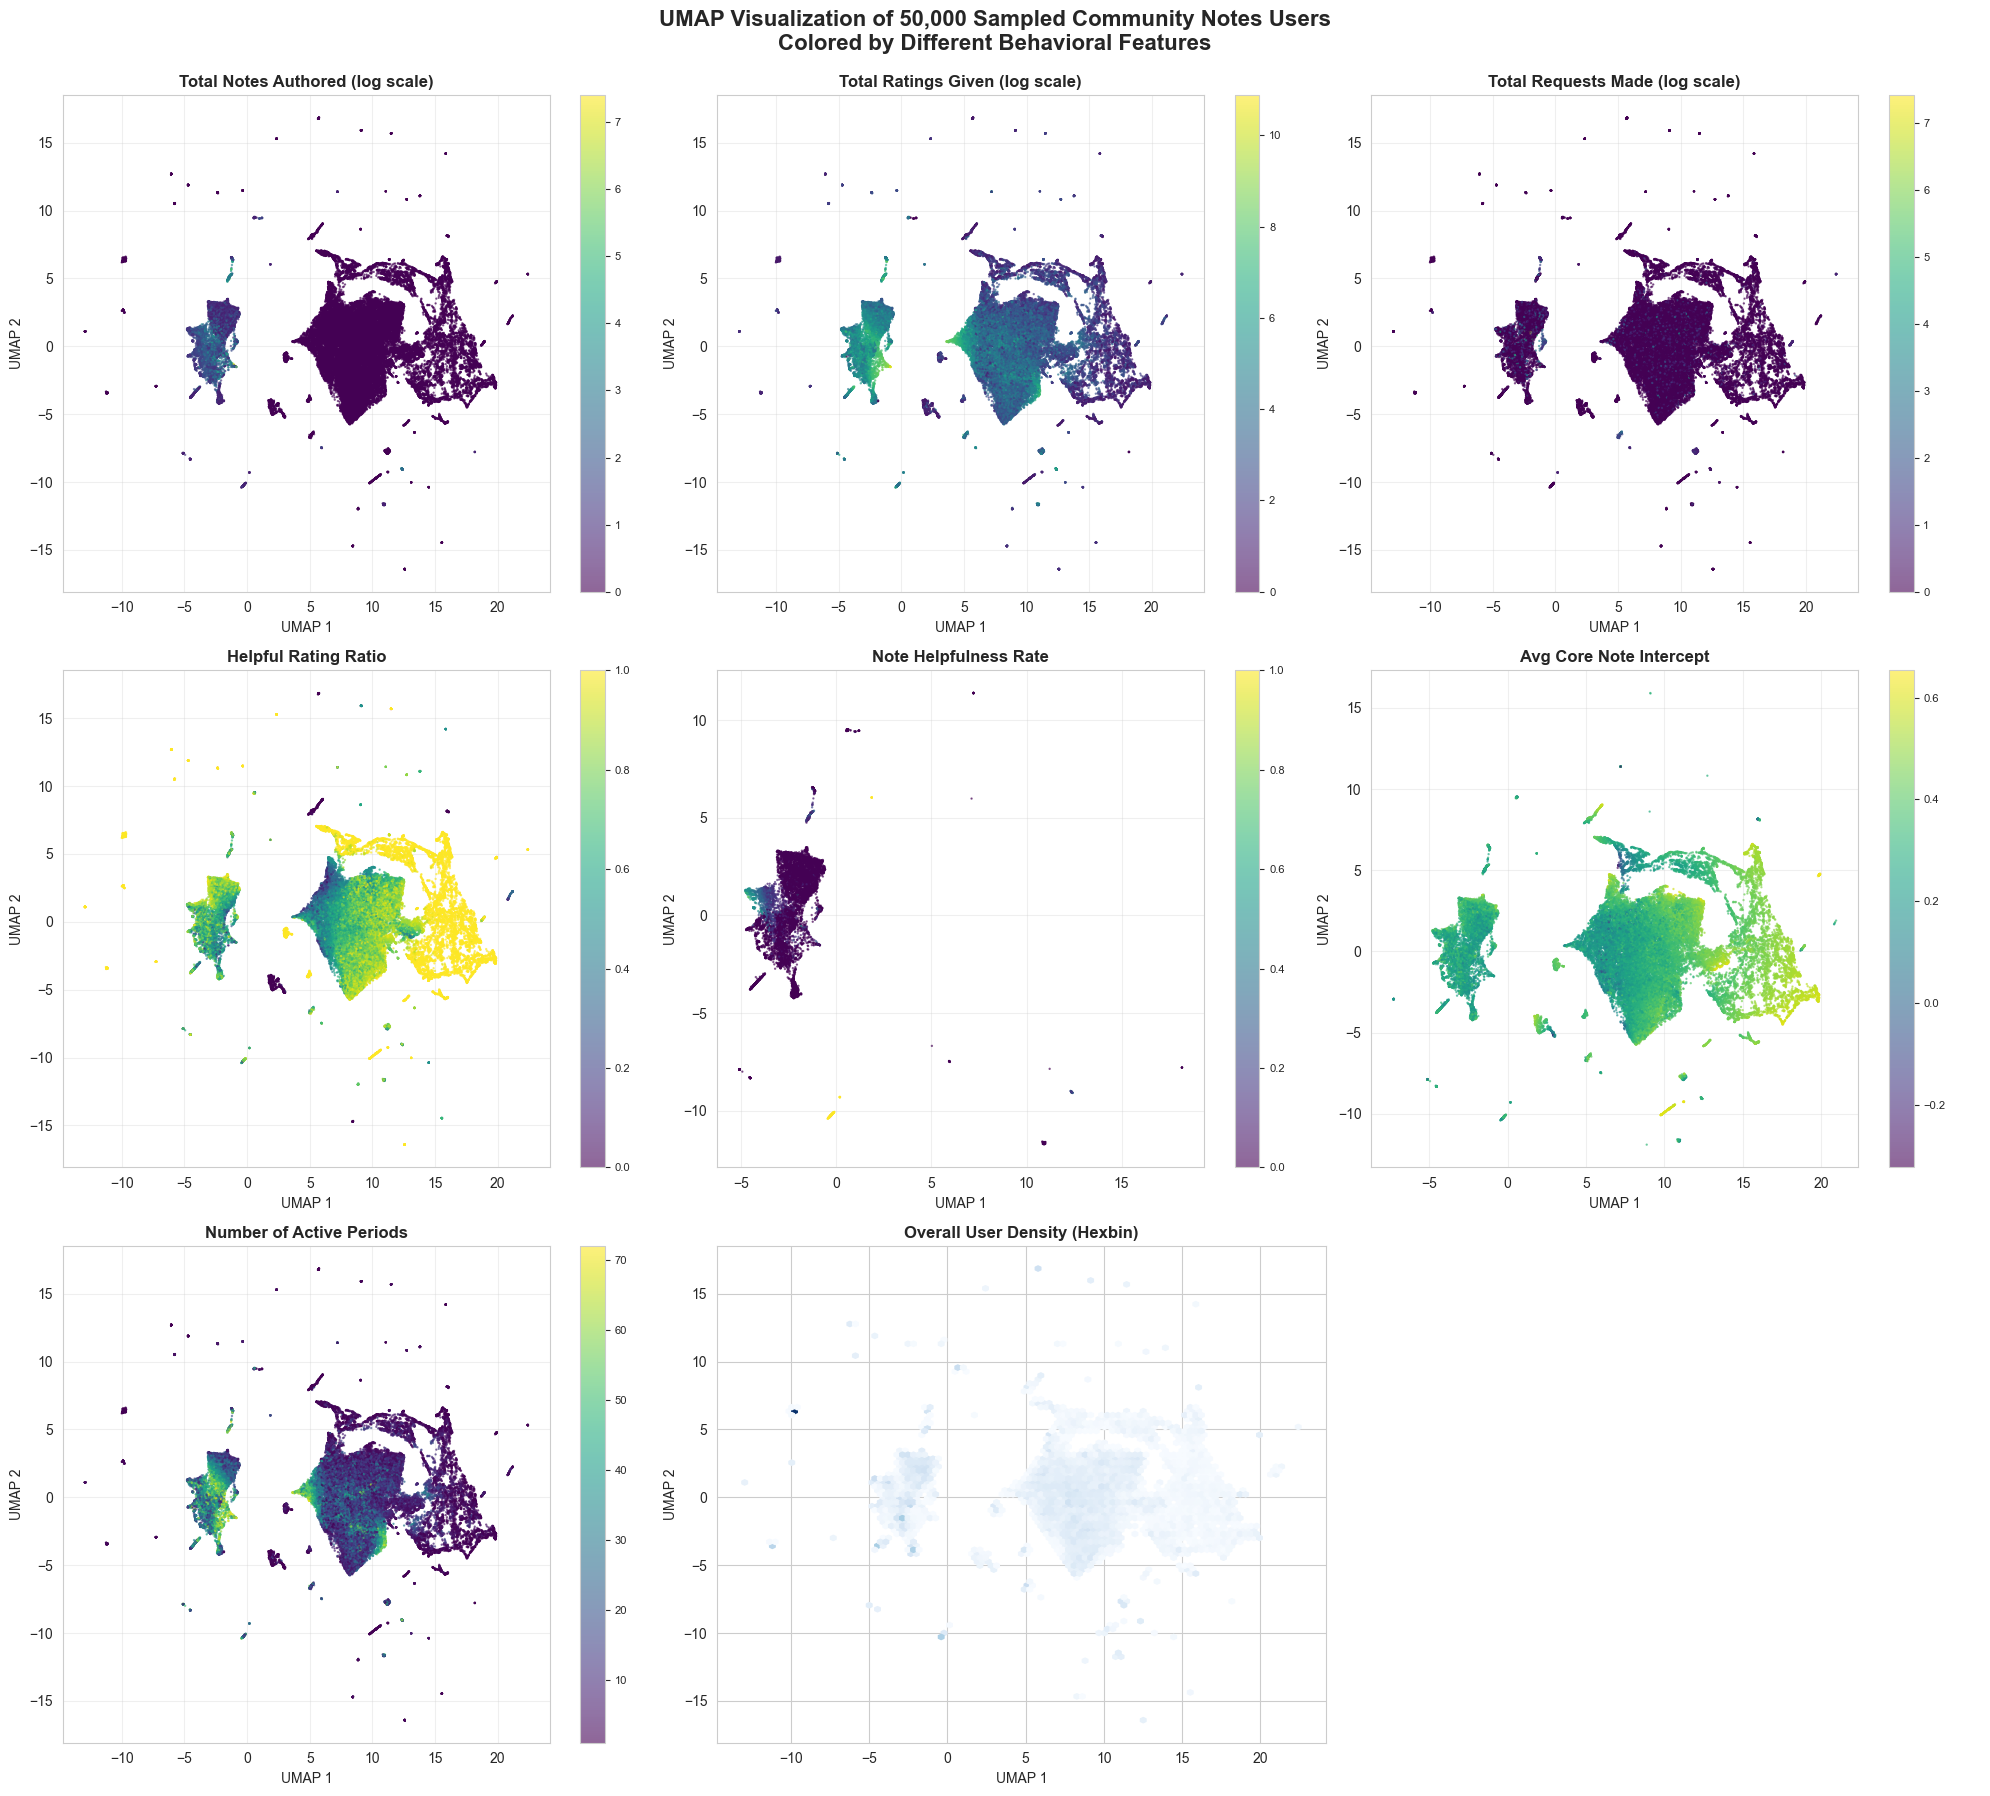


✅ Visualization complete!


In [6]:
print("📊 Creating UMAP visualizations colored by different features...\n")

# Select interesting features to color by
color_features = {
    'total_notes': 'Total Notes Authored',
    'total_ratings': 'Total Ratings Given',
    'total_requests': 'Total Requests Made',
    'helpful_rating_ratio': 'Helpful Rating Ratio',
    'note_helpful_rate': 'Note Helpfulness Rate',
    'avg_intercept': 'Avg Core Note Intercept',
    'active_periods': 'Number of Active Periods'
}

# Create multi-panel visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

for idx, (feature, title) in enumerate(color_features.items()):
    ax = axes[idx]
    
    # Get feature values for coloring (from sampled data)
    colors = user_features_sample[feature].values
    
    # Use log scale for count features
    if feature in ['total_notes', 'total_ratings', 'total_requests']:
        colors = np.log1p(colors)  # log(1+x) to handle zeros
        title = f"{title} (log scale)"
    
    # Create scatter plot
    scatter = ax.scatter(
        X_umap[:, 0], 
        X_umap[:, 1],
        c=colors,
        cmap='viridis',
        s=0.5,
        alpha=0.6,
        rasterized=True  # Better performance for large plots
    )
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('UMAP 1', fontsize=10)
    ax.set_ylabel('UMAP 2', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.ax.tick_params(labelsize=8)

# Overall density plot in the last panels
ax = axes[7]
ax.hexbin(X_umap[:, 0], X_umap[:, 1], gridsize=100, cmap='Blues', mincnt=1)
ax.set_title('Overall User Density (Hexbin)', fontsize=12, fontweight='bold')
ax.set_xlabel('UMAP 1', fontsize=10)
ax.set_ylabel('UMAP 2', fontsize=10)

# Hide the last unused panel
axes[8].axis('off')

plt.suptitle(f'UMAP Visualization of {len(user_features_sample):,} Sampled Community Notes Users\nColored by Different Behavioral Features',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")

🎯 Creating focused UMAP plots by user archetype...

User archetypes:
archetype
Rater          49861
Mixed             53
Requester         50
Note Author       36
Name: count, dtype: int64



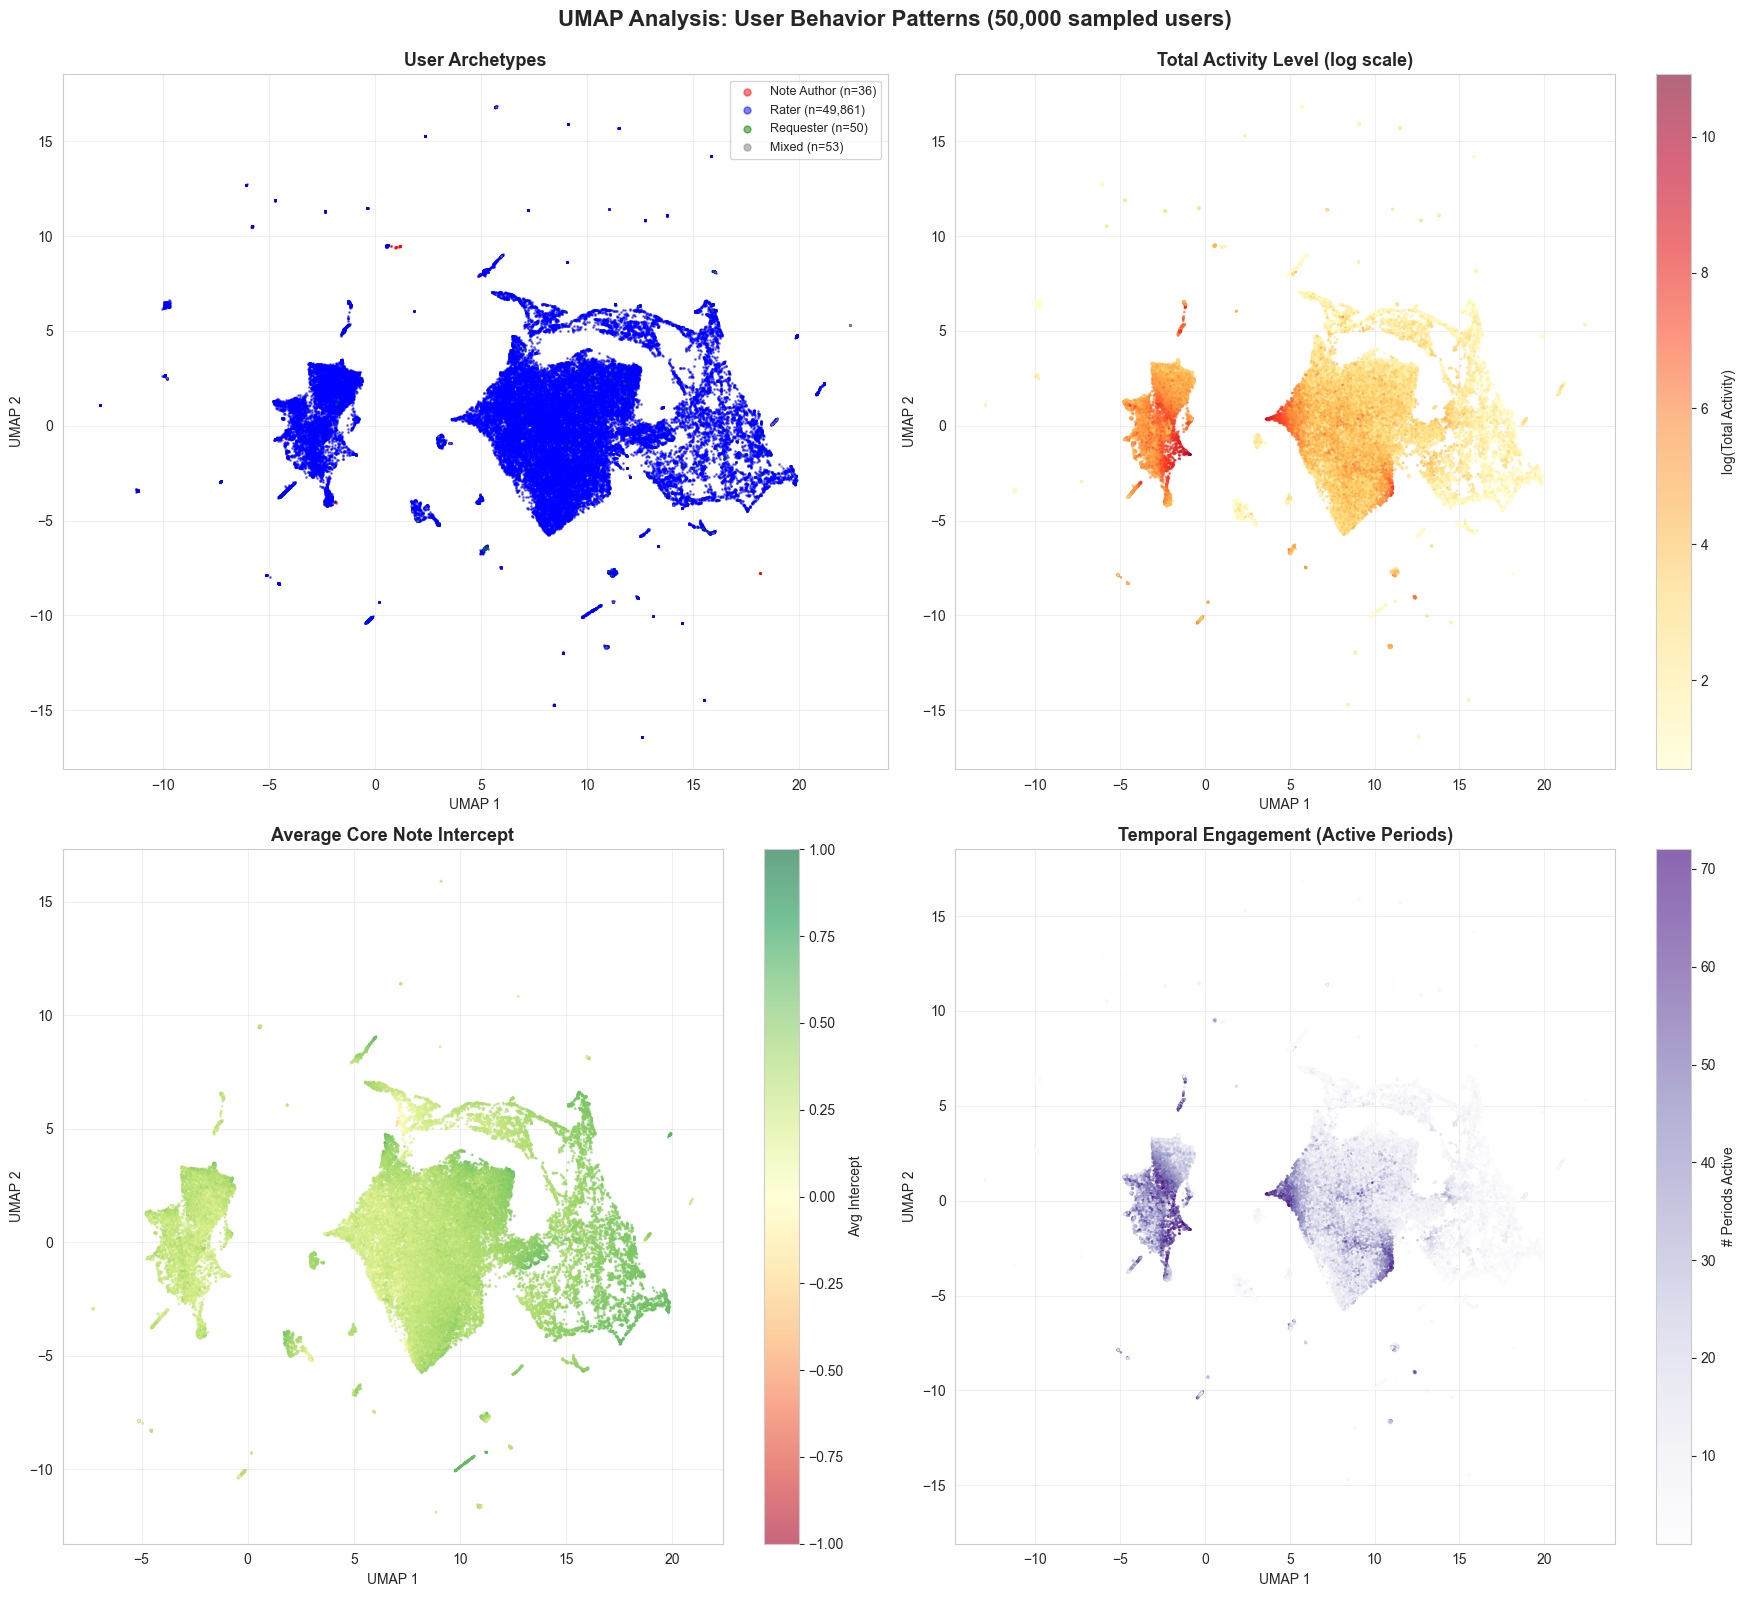


✅ Archetype visualization complete!


: 

In [ ]:
print("🎯 Creating focused UMAP plots by user archetype...\n")

# Define user archetypes based on dominant activity (on sampled data)
user_features_sample['archetype'] = 'Mixed'
user_features_sample.loc[
    (user_features_sample['total_notes'] > user_features_sample['total_ratings']) & 
    (user_features_sample['total_notes'] > user_features_sample['total_requests']), 
    'archetype'
] = 'Note Author'
user_features_sample.loc[
    (user_features_sample['total_ratings'] > user_features_sample['total_notes']) & 
    (user_features_sample['total_ratings'] > user_features_sample['total_requests']), 
    'archetype'
] = 'Rater'
user_features_sample.loc[
    (user_features_sample['total_requests'] > user_features_sample['total_notes']) & 
    (user_features_sample['total_requests'] > user_features_sample['total_ratings']), 
    'archetype'
] = 'Requester'

# Count archetypes
archetype_counts = user_features_sample['archetype'].value_counts()
print("User archetypes:")
print(archetype_counts)
print()

# Create visualization by archetype
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Plot 1: All archetypes
ax = axes[0, 0]
archetype_colors = {'Note Author': 'red', 'Rater': 'blue', 'Requester': 'green', 'Mixed': 'gray'}
for archetype, color in archetype_colors.items():
    mask = user_features_sample['archetype'] == archetype
    ax.scatter(
        X_umap[mask, 0], X_umap[mask, 1],
        c=color, label=f'{archetype} (n={mask.sum():,})',
        s=1, alpha=0.5, rasterized=True
    )
ax.set_title('User Archetypes', fontsize=13, fontweight='bold')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.legend(markerscale=5, fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 2: Activity level (total combined activity)
ax = axes[0, 1]
total_activity = user_features_sample['total_notes'] + user_features_sample['total_ratings'] + user_features_sample['total_requests']
scatter = ax.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=np.log1p(total_activity),
    cmap='YlOrRd',
    s=1, alpha=0.6, rasterized=True
)
ax.set_title('Total Activity Level (log scale)', fontsize=13, fontweight='bold')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
plt.colorbar(scatter, ax=ax, label='log(Total Activity)')
ax.grid(True, alpha=0.3)

# Plot 3: Quality score (intercept)
ax = axes[1, 0]
scatter = ax.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=user_features_sample['avg_intercept'],
    cmap='RdYlGn',
    s=1, alpha=0.6, rasterized=True,
    vmin=-1, vmax=1  # Center at 0
)
ax.set_title('Average Core Note Intercept', fontsize=13, fontweight='bold')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
plt.colorbar(scatter, ax=ax, label='Avg Intercept')
ax.grid(True, alpha=0.3)

# Plot 4: Temporal engagement
ax = axes[1, 1]
scatter = ax.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=user_features_sample['active_periods'],
    cmap='Purples',
    s=1, alpha=0.6, rasterized=True
)
ax.set_title('Temporal Engagement (Active Periods)', fontsize=13, fontweight='bold')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
plt.colorbar(scatter, ax=ax, label='# Periods Active')
ax.grid(True, alpha=0.3)

plt.suptitle(f'UMAP Analysis: User Behavior Patterns ({len(user_features_sample):,} sampled users)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✅ Archetype visualization complete!")